## Chapter 2 문자 RNN을 이용해 자연어 품사 태깅하기

In [ ]:
!pip install konlpy torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 46.7 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchinfo import summary

from konlpy.corpus import kolaw
from konlpy.tag import Okt

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

In [ ]:
seed = 827
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 2.2 품사 태깅 데이터

In [ ]:
with kolaw.open('constitution.txt') as f:
  corpus = f.read()
print(corpus[:40])

대한민국헌법

유구한 역사와 전통에 빛나는 우리 대한국민은 3·1운동으로


In [ ]:
vocab = list(sorted(set(corpus)))
vocab.insert(0, '')
char_to_index = {char: i for i, char in enumerate(vocab)}
char_to_index

{'': 0,
 '\n': 1,
 ' ': 2,
 '"': 3,
 ',': 4,
 '.': 5,
 '0': 6,
 '1': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15,
 '<': 16,
 '>': 17,
 '·': 18,
 '①': 19,
 '②': 20,
 '③': 21,
 '④': 22,
 '⑤': 23,
 '⑥': 24,
 '⑦': 25,
 '가': 26,
 '각': 27,
 '간': 28,
 '감': 29,
 '강': 30,
 '같': 31,
 '개': 32,
 '거': 33,
 '건': 34,
 '걸': 35,
 '검': 36,
 '것': 37,
 '게': 38,
 '격': 39,
 '견': 40,
 '결': 41,
 '겸': 42,
 '경': 43,
 '계': 44,
 '고': 45,
 '공': 46,
 '과': 47,
 '관': 48,
 '광': 49,
 '교': 50,
 '구': 51,
 '국': 52,
 '군': 53,
 '권': 54,
 '궐': 55,
 '규': 56,
 '균': 57,
 '그': 58,
 '근': 59,
 '금': 60,
 '급': 61,
 '기': 62,
 '긴': 63,
 '까': 64,
 '나': 65,
 '날': 66,
 '남': 67,
 '납': 68,
 '내': 69,
 '넘': 70,
 '녀': 71,
 '년': 72,
 '념': 73,
 '녕': 74,
 '노': 75,
 '농': 76,
 '누': 77,
 '는': 78,
 '능': 79,
 '니': 80,
 '닌': 81,
 '다': 82,
 '단': 83,
 '달': 84,
 '담': 85,
 '답': 86,
 '당': 87,
 '대': 88,
 '더': 89,
 '덕': 90,
 '던': 91,
 '데': 92,
 '도': 93,
 '독': 94,
 '동': 95,
 '되': 96,
 '된': 97,
 '될': 98,
 '두': 99,
 '둔': 100,

In [ ]:
def text_to_sequence(text):
  return [char_to_index[char] for char in text]
text_to_sequence("대한민국")

[88, 350, 149, 52]

In [ ]:
okt = Okt()
tagged = okt.pos(corpus)
tagged

[('대한민국', 'Noun'),
 ('헌법', 'Noun'),
 ('\n\n', 'Foreign'),
 ('유구', 'Noun'),
 ('한', 'Josa'),
 ('역사', 'Noun'),
 ('와', 'Josa'),
 ('전통', 'Noun'),
 ('에', 'Josa'),
 ('빛나는', 'Verb'),
 ('우리', 'Noun'),
 ('대', 'Modifier'),
 ('한', 'Modifier'),
 ('국민', 'Noun'),
 ('은', 'Josa'),
 ('3', 'Number'),
 ('·', 'Punctuation'),
 ('1', 'Number'),
 ('운동', 'Noun'),
 ('으로', 'Josa'),
 ('건립', 'Noun'),
 ('된', 'Verb'),
 ('대한민국', 'Noun'),
 ('임시정부', 'Noun'),
 ('의', 'Josa'),
 ('법', 'Noun'),
 ('통과', 'Noun'),
 ('불의', 'Noun'),
 ('에', 'Josa'),
 ('항거', 'Noun'),
 ('한', 'Josa'),
 ('4', 'Number'),
 ('·', 'Punctuation'),
 ('19', 'Number'),
 ('민주', 'Noun'),
 ('이념', 'Noun'),
 ('을', 'Josa'),
 ('계승', 'Noun'),
 ('하고', 'Josa'),
 (',', 'Punctuation'),
 ('조국', 'Noun'),
 ('의', 'Josa'),
 ('민주', 'Noun'),
 ('개혁', 'Noun'),
 ('과', 'Josa'),
 ('평화', 'Noun'),
 ('적', 'Suffix'),
 ('통일', 'Noun'),
 ('의', 'Josa'),
 ('사명', 'Noun'),
 ('에', 'Josa'),
 ('입', 'Noun'),
 ('각하', 'Noun'),
 ('여', 'Josa'),
 ('정의', 'Noun'),
 ('·', 'Punctuation'),
 ('인도', 'Noun'),

In [ ]:
words, tags = zip(*tagged)
print(words)
print(tags)

('대한민국', '헌법', '\n\n', '유구', '한', '역사', '와', '전통', '에', '빛나는', '우리', '대', '한', '국민', '은', '3', '·', '1', '운동', '으로', '건립', '된', '대한민국', '임시정부', '의', '법', '통과', '불의', '에', '항거', '한', '4', '·', '19', '민주', '이념', '을', '계승', '하고', ',', '조국', '의', '민주', '개혁', '과', '평화', '적', '통일', '의', '사명', '에', '입', '각하', '여', '정의', '·', '인도', '와', '동포', '애', '로써', '민족', '의', '단결', '을', '공고', '히', '하고', ',', '모든', '사회', '적', '폐습', '과', '불의', '를', '타파', '하며', ',', '자율', '과', '조화', '를', '바탕', '으로', '자유민주', '적', '기', '본', '질서', '를', '더욱', '확고히', '하여', '정치', '·', '경제', '·', '사회', '·', '문화', '의', '모든', '영역', '에', '있어서', '각인', '의', '기회', '를', '균등히', '하고', ',', '능력', '을', '최고', '도로', '발휘', '하게', '하며', ',', '자유', '와', '권리', '에', '따르는', '책임', '과', '의무', '를', '완수', '하게', '하여', ',', '안', '으로는', '국민', '생활', '의', '균등한', '향상', '을', '기하', '고', '밖', '으로는', '항구', '적', '인', '세계', '평화', '와', '인류', '공영', '에', '이바지', '함', '으로써', '우리', '들', '과', '우리', '들', '의', '자손', '의', '안전', '과', '자유', '와', '행복', '을', '영원히', '확보', '할', '것',

In [ ]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
words_len = [len(word) for word in words]
print(len(words_len))
max_len = max(words_len)
mean_len = sum(words_len) / len(words_len)
print("MAX:", max_len)
print("MEAN:", mean_len)

8796
MAX: 9
MEAN: 1.7107776261937244


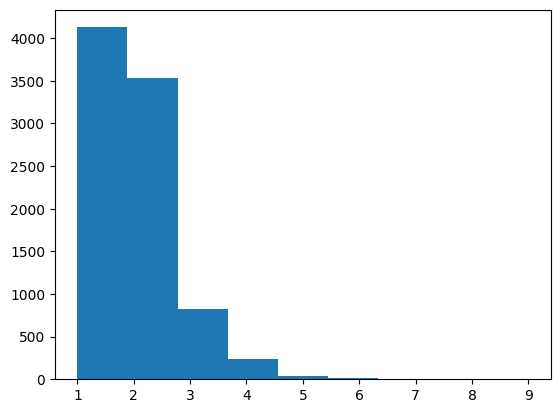

In [ ]:
plt.hist(words_len, bins=9)
plt.show()

In [ ]:
train_x = [torch.Tensor(text_to_sequence(word)) for word in words]

In [ ]:
nn.utils.rnn.pad_sequence(train_x, batch_first=True).size()

torch.Size([8796, 9])

In [ ]:
class_names = list(sorted(set(tags)))
class_names

['Adjective',
 'Adverb',
 'Conjunction',
 'Determiner',
 'Exclamation',
 'Foreign',
 'Josa',
 'Modifier',
 'Noun',
 'Number',
 'Punctuation',
 'Suffix',
 'Verb']

In [ ]:
class TokenizerDataset(Dataset):
  def __init__(self):
    corpus =  kolaw.open('constitution.txt').read()
    tokenizer = Okt()

    self.vocab = list(sorted(set(corpus)))
    self.vocab.insert(0, '')
    self.char_to_index = {char: i for i, char in enumerate(self.vocab)}

    self.data, self.labels = zip(*tokenizer.pos(corpus))
    self.data = [torch.LongTensor(self.text_to_sequence(word)) for word in self.data]
    self.data = nn.utils.rnn.pad_sequence(self.data, batch_first=True)

    self.class_names = list(sorted(set(self.labels)))
    self.labels = [self.class_names.index(label) for label in self.labels]

  def text_to_sequence(self, text):
    return [self.char_to_index[char] for char in text]

  def sequence_to_text(self, sequence):
    if isinstance(sequence, torch.Tensor):
      sequence = [int(i) for i in sequence]
    return ''.join([self.vocab[i] for i in sequence])

  def __getitem__(self, i):
    return self.data[i], self.labels[i]

  def __len__(self):
    return len(self.data)

In [ ]:
dataset = TokenizerDataset()

In [ ]:
data, label = dataset[0]
print(dataset.sequence_to_text(data), data)
print(dataset.class_names[label], label)

대한민국 tensor([ 88, 350, 149,  52,   0,   0,   0,   0,   0])
Noun 8


In [ ]:
def get_dataset(train=0.8, val=0.1,random_seed=827):
  origin = TokenizerDataset()

  train_samples = int(len(origin) * train)
  val_samples = int(len(origin) * val)
  test_samples = len(origin) - train_samples - val_samples

  torch.manual_seed(random_seed)
  trainset, valset, testset = torch.utils.data.random_split(
    origin,
    (train_samples, val_samples, test_samples),
  )

  return trainset, valset, testset

trainset, valset, testset = get_dataset()
print(len(trainset), len(valset), len(testset))

7036 879 881


### 2.3 RNN 분류기 모델

In [ ]:
class PosTagger(nn.Module):
  def __init__(self, vocab_size, hidden_dims, layers, seq_len, classes):
    super(PosTagger, self).__init__()
    self.hidden_dims = hidden_dims
    self.seq_len = seq_len

    self.embedding = nn.Embedding(vocab_size, hidden_dims)
    self.lstm = nn.LSTM(hidden_dims, hidden_dims, layers, batch_first=True)
    self.fc = nn.Linear(hidden_dims*seq_len, classes, bias=True)

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.lstm(x)
    x = x.reshape((-1, self.hidden_dims * self.seq_len))
    x = self.fc(x)
    return x

In [ ]:
model = PosTagger(len(dataset.vocab), 128, 2, 9, len(dataset.class_names))
summary(model, input_data=torch.randint(0, 380, (2, 9)))

Layer (type:depth-idx)                   Output Shape              Param #
PosTagger                                [2, 13]                   --
├─Embedding: 1-1                         [2, 9, 128]               48,768
├─LSTM: 1-2                              [2, 9, 128]               264,192
├─Linear: 1-3                            [2, 13]                   14,989
Total params: 327,949
Trainable params: 327,949
Non-trainable params: 0
Total mult-adds (M): 4.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 1.31
Estimated Total Size (MB): 1.35

### 2.4 모델 학습

In [ ]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  model.train()

  running_loss = 0
  correct = 0

  with tqdm(dataloader) as pbar:
    for i, (data, targets) in enumerate(pbar):
      data, targets = data.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

      with torch.no_grad():
        _, predicted = torch.max(outputs, 1)
        correct += predicted.eq(targets.view_as(predicted)).sum()

    data_num = len(dataloader.dataset)
    acc = 100. * correct / data_num

  return running_loss/len(dataloader), acc

In [ ]:
def validation(model, dataloader, criterion, epoch, device):
  model.eval()

  correct = 0
  running_loss = 0.

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

        _, predicted = torch.max(outputs, 1)
        correct += predicted.eq(targets.view_as(predicted)).sum()

  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num

  return running_loss/len(dataloader), acc

In [ ]:
EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.001

trainset, valset, testset = get_dataset()

# dataloader
train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
  dataset=testset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)

vocab_len = len(trainset.dataset.vocab)
classes = len(trainset.dataset.class_names)
model = PosTagger(vocab_len, 128, 2, 9, classes)

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model = model.to(device)
criterion = criterion.to(device)

max_acc = 0
# Start Training
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  print(f"[{epoch}/{EPOCH}] train loss: {tloss:.4f} train acc: {tacc:.2f}%")
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)
  print(f"[{epoch}/{EPOCH}] valid loss: {vloss:.4f} valid acc: {vacc:.2f}%\n")

  scheduler.step()

  if vacc > max_acc:
    torch.save(model.state_dict(), "best.pth")

LR: [0.001]


100%|██████████| 55/55 [00:06<00:00,  8.69it/s, loss=0.664]


[0/10] train loss: 1.3794 train acc: 58.70%


100%|██████████| 7/7 [00:00<00:00, 27.43it/s, loss=0.554]


[0/10] valid loss: 0.5833 valid acc: 82.03%

LR: [0.001]


100%|██████████| 55/55 [00:04<00:00, 13.27it/s, loss=0.0972]


[1/10] train loss: 0.3013 train acc: 91.81%


100%|██████████| 7/7 [00:00<00:00, 25.55it/s, loss=0.285]


[1/10] valid loss: 0.1976 valid acc: 95.56%

LR: [0.001]


100%|██████████| 55/55 [00:06<00:00,  8.66it/s, loss=0.0437]


[2/10] train loss: 0.1234 train acc: 96.50%


100%|██████████| 7/7 [00:00<00:00, 11.45it/s, loss=0.216]


[2/10] valid loss: 0.1401 valid acc: 96.70%

LR: [0.0005]


100%|██████████| 55/55 [00:04<00:00, 13.18it/s, loss=0.113]


[3/10] train loss: 0.0844 train acc: 97.90%


100%|██████████| 7/7 [00:00<00:00, 25.32it/s, loss=0.21]


[3/10] valid loss: 0.1248 valid acc: 96.81%

LR: [0.0005]


100%|██████████| 55/55 [00:04<00:00, 13.34it/s, loss=0.103]


[4/10] train loss: 0.0749 train acc: 97.95%


100%|██████████| 7/7 [00:00<00:00, 25.08it/s, loss=0.215]


[4/10] valid loss: 0.1189 valid acc: 97.27%

LR: [0.0005]


100%|██████████| 55/55 [00:05<00:00,  9.78it/s, loss=0.0424]


[5/10] train loss: 0.0671 train acc: 98.10%


100%|██████████| 7/7 [00:00<00:00, 21.58it/s, loss=0.224]


[5/10] valid loss: 0.1161 valid acc: 97.04%

LR: [0.00025]


100%|██████████| 55/55 [00:03<00:00, 14.79it/s, loss=0.0533]


[6/10] train loss: 0.0571 train acc: 98.32%


100%|██████████| 7/7 [00:00<00:00, 24.93it/s, loss=0.212]


[6/10] valid loss: 0.1130 valid acc: 97.16%

LR: [0.00025]


100%|██████████| 55/55 [00:04<00:00, 13.41it/s, loss=0.0577]


[7/10] train loss: 0.0561 train acc: 98.35%


100%|██████████| 7/7 [00:00<00:00, 25.54it/s, loss=0.219]


[7/10] valid loss: 0.1125 valid acc: 97.16%

LR: [0.00025]


100%|██████████| 55/55 [00:05<00:00, 10.35it/s, loss=0.163]


[8/10] train loss: 0.0514 train acc: 98.35%


100%|██████████| 7/7 [00:00<00:00, 17.86it/s, loss=0.216]


[8/10] valid loss: 0.1114 valid acc: 97.04%

LR: [0.000125]


100%|██████████| 55/55 [00:04<00:00, 12.70it/s, loss=0.0526]


[9/10] train loss: 0.0479 train acc: 98.44%


100%|██████████| 7/7 [00:00<00:00, 26.39it/s, loss=0.233]


[9/10] valid loss: 0.1161 valid acc: 97.16%



In [ ]:
tloss, tacc = validation(model, test_loader, criterion, epoch, device)
print(f"\n[TEST] loss: {tloss:.4f} acc: {tacc:.2f}%")

100%|██████████| 7/7 [00:00<00:00, 25.04it/s, loss=0.0854]


[TEST] loss: 0.0812 acc: 97.16%


In [ ]:
def inference(text, dataset, model):
  input = dataset.text_to_sequence(text)
  input = torch.nn.functional.pad(torch.LongTensor(input), (0, 9-len(input)))
  logit = model(input)
  output = torch.argmax(logit)
  return dataset.class_names[output.item()]

In [ ]:
dataset = TokenizerDataset()

vocab_len = len(dataset.vocab)
classes = len(dataset.class_names)
model = PosTagger(vocab_len, 128, 2, 9, classes)
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

In [ ]:
print(inference("모든", dataset, model))
print(inference("권력", dataset, model))
print(inference("은", dataset, model))
print(inference("국민", dataset, model))
print(inference("으로부터", dataset, model))
print(inference("나온다", dataset, model))

'Noun'

'Noun'

'Noun'

'Josa'

'Verb'